### Google.colab
Only execute this cell when use on google colab platform (colab).

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://github.com/Nak007/randomforest_analysis">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

Mount with google drive.

In [ ]:
from google.colab import drive
drive.mount('/content/dirve')

# Import other libraries required.
!git clone 'http://github.com/Nak007/randomforest_analysis.git'

In [1]:
import pandas as pd, numpy as np, pickle, sys
import matplotlib.pyplot as plt
pd.options.display.float_format = '{:,.4f}'.format

# scikit-learn library
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split as tts
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (make_scorer,
                             roc_auc_score, 
                             accuracy_score,
                             f1_score, log_loss)

try: sys.path.append('/content/randomforest_analysis')
except: pass

from varclus import *
from cluster_visualization import *
from RandomSearch import *
from model_validation import *
from FeatureImportance import *
from TreeExplainer import *
from Calibration import *
from Factor_Analysis import *
from Univariate import *

Generate a random n-class classification problem [(**`make_classification`**)](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html).

In [37]:
n_features = 200
n_informative = 10
n_remain = n_features - n_informative
p_redundant = 0.5
n_redundant = int(p_redundant * n_remain)
n_repeated  = n_remain - n_redundant

X, y = make_classification(n_samples     = 10000, 
                           n_features    = n_features, 
                           n_informative = n_informative, 
                           n_redundant   = n_redundant,
                           n_repeated    = n_repeated,
                           random_state  = 100, 
                           shuffle       = True, 
                           n_classes     = 2, 
                           weights       = [0.9, 0.1])

Convert **`X`** into pandas DataFrame.

In [38]:
digit = int(np.ceil(np.log10(X.shape[1])))
X = pd.DataFrame(X, columns=["feature_" + str(n).zfill(digit) 
                             for n in range(1, X.shape[1]+1)]) 

**<font size=5 color='green'> Compare samples </font>**

In [39]:
compare = Compare2samp(frac=0.01).fit(X.loc[y==0], X.loc[y==1])

Summary of results

In [40]:
compare.info.sample(5)

,chi2_chisq,chi2_df,chi2_pvalue,chi2_bins,ks_stat,ks_pvalue,psi,dtype
variable,,,,,,,,
feature_109,9.2741,6,0.1587,7,0.1533,0.0000,0.1006,float32
feature_092,28.7341,7,0.0002,8,0.1300,0.0000,0.1269,float32
feature_043,22.3409,6,0.0011,7,0.2185,0.0000,0.2855,float32
feature_025,3.1984,7,0.8661,8,0.0507,0.0164,0.3553,float32
feature_021,22.3158,5,0.0005,6,0.1393,0.0000,0.1447,float32


To visualize, use `plotting`.

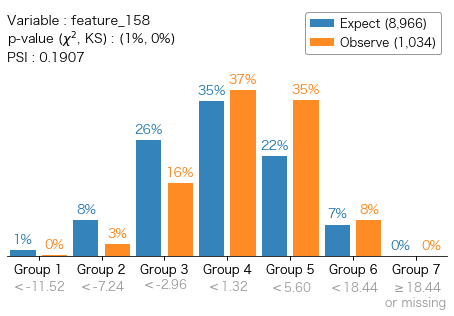

In [42]:
ax = compare.plotting(np.random.choice(list(X)), 
                      xticklabel_format="{:,.2f}".format)

Select feature, whose $\chi^{2}$ p-value $\leq$ 1%.

In [44]:
chi2_cond = compare.info["chi2_pvalue"]<=0.01
X = X.loc[:,compare.info.loc[chi2_cond].index].copy()
print("There are {:,d} out of {:,d} features, that " 
      "satisfy the condition(s).".format(X.shape[1], len(chi2_cond)))

There are 119 out of 200 features, that satisfy the condition(s).


### <font color="green" size=5> Variable Clustering </font>

In [45]:
vc = VariableClustering(option="varexp", maxclus=len(X)-1, proportion=0.75).fit(X)

In [46]:
print("No. of clusters: {:,d}".format(vc.info.shape[0]))
vc.info.head()

No. of clusters: 25


,N_Vars,Eigval1,Eigval2,VarProp,min_RSO,max_RSN,max_RSr
Cluster,,,,,,,
1,9,7.3340,1.0424,0.8149,0.3203,0.6439,1.1953
2,8,6.7251,1.0764,0.8406,0.7634,0.5392,0.4379
3,7,5.6596,1.0345,0.8085,0.5909,0.4816,0.5976
4,5,3.9405,1.0595,0.7881,0.6432,0.6598,0.5108
5,6,5.2145,0.5713,0.8691,0.6053,0.5899,0.5813


In [47]:
vc.r2.head(10)

RS_Own  RS_NC  RS_Ratio
Cluster Variable                            
1       feature_079  0.9032 0.4865    0.1885
        feature_084  0.9032 0.4865    0.1885
        feature_148  0.9032 0.4865    0.1885
        feature_200  0.9032 0.4865    0.1885
        feature_013  0.8725 0.6098    0.3268
        feature_022  0.8725 0.6098    0.3268
        feature_012  0.8280 0.6439    0.4831
        feature_101  0.8280 0.6439    0.4831
        feature_074  0.3203 0.4313    1.1953
2       feature_055  0.9154 0.5392    0.1836

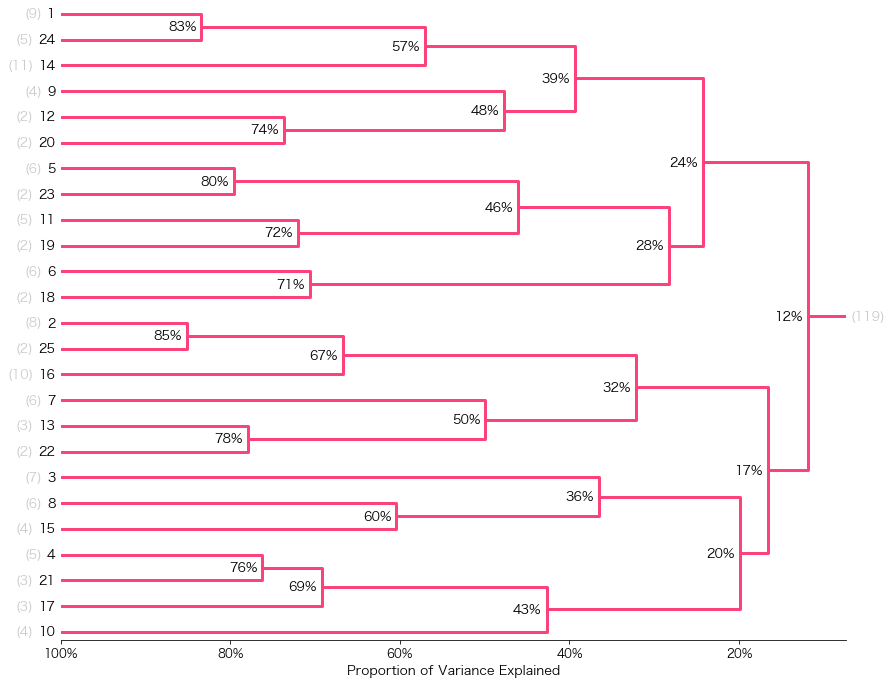

In [50]:
ax = vc.plot(k=25)

We can use **`cluster_matrix`** to visualize results from **`VariableClustering`** through a matrix of scatter plots.

In [51]:
cluster = 2
index = vc.clus_corr.index.get_level_values(0)==cluster
X0 = X[vc.clus_corr.loc[index].index.get_level_values(1)]
X0 = (X0 - X0.mean()) / X0.std()
X0.columns = [c.replace("_","\n") for c in list(X0)]

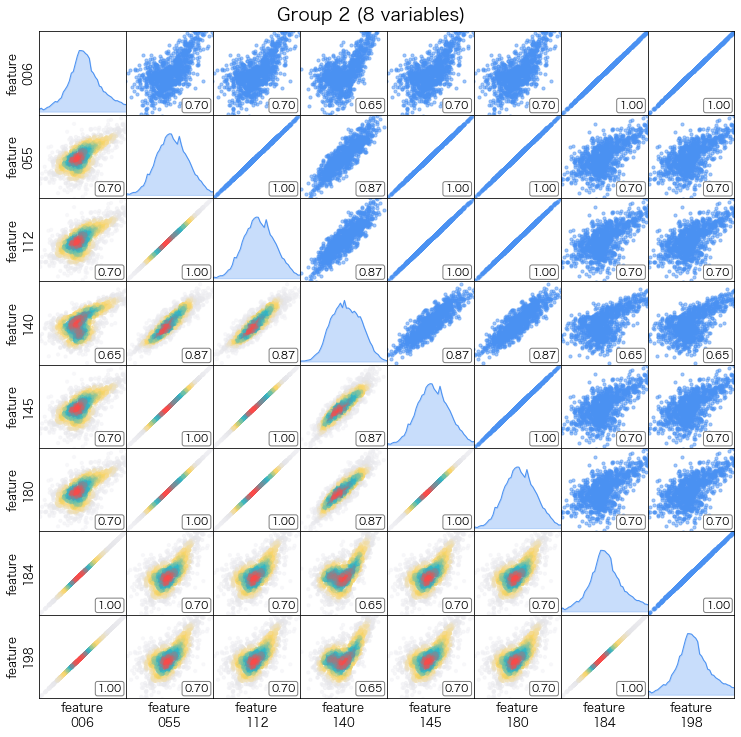

In [52]:
cmap = create_cmap(["#fe4a49" , "#2ab7ca" , "#fed766" , "#e6e6ea" , "#f4f4f8"])
axes = cluster_matrix(X0, off_diagonal="both", scatter_kwds={"cmap":cmap}, colors=["#4a91f2"])
plt.gcf().suptitle('Group {} ({:,d} variables)'.format(cluster, X0.shape[1]), fontsize=18)
plt.tight_layout()

Let's select variable, with the lowest **RS_Ratio** from each **Cluster**.

In [53]:
X = X[vc.r2.reset_index().groupby('Cluster').first()["Variable"].values].copy()

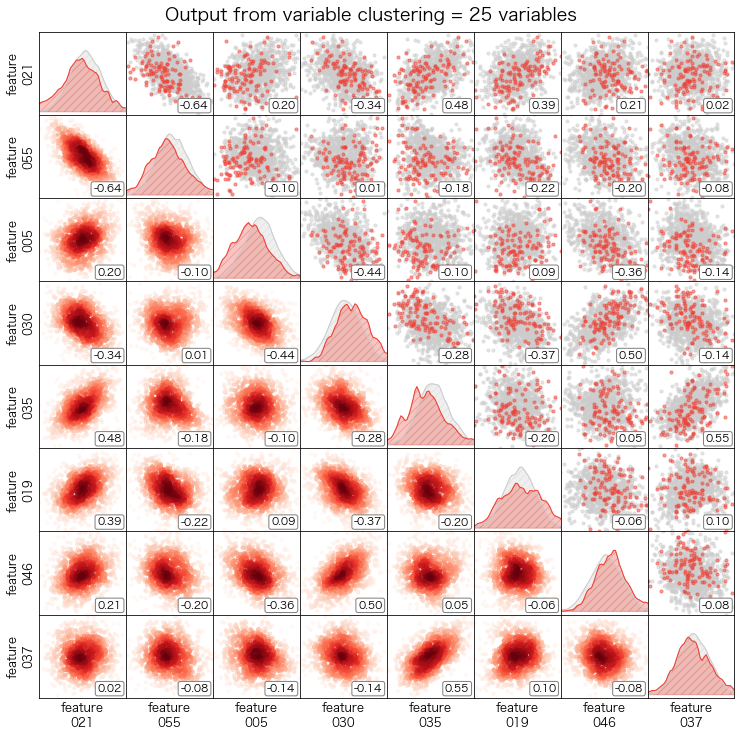

In [54]:
index = np.random.choice(range(X.shape[1]), size=8, replace=False)
X0 = X.iloc[:,index].copy()
X0.columns = [c.replace("_","\n") for c in list(X0)]
axes = cluster_matrix(X0, y=y, off_diagonal="both",
                      scatter_kwds=dict(cmap="Reds"),
                      hist_kwds=dict(sigma=1, fill_kwds=dict(hatch="///")), 
                      show_corr=True, colors=["#cccccc", "#ee4035"])
plt.gcf().suptitle('Output from variable clustering = {:,d} variables'
                   .format(X.shape[1]), fontsize=18)
plt.tight_layout()

### <font color="green" size=5> Split train and test sets </font>

Split data into **train**, and **test** sets [(**`train_test_split`**)](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [55]:
tts_kwargs = {"test_size"   : 0.3, 
              "shuffle"     : True, 
              "random_state": 0}
X_train, X_test, y_train, y_test = tts(X, y, **tts_kwargs)
n_samples, n_features = X_train.shape

Create [**`RandomForestClassifier`**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)'s parameter distributions (**`param_distributions`**). Input must be dictionary with parameters names (`str`) as keys and distributions or lists of parameters to try. Distributions must provide a ``rvs`` method for sampling (such as those from scipy.stats.distributions). If a list is given, it is sampled uniformly. If a list of dicts is given, first a dict 
is sampled uniformly, and then a parameter is sampled using that dict as above.

In [56]:
param_grids0 = {"max_depth"    : np.arange(3, np.ceil(np.log2(n_samples))).astype(int),  
                "class_weight" : get_classweights(y=y_train, num=5),
                "max_features" : np.arange(np.floor(max(np.log2(n_features), 
                                                        np.sqrt(n_features))-1), 10).astype(int), 
                "criterion"    : ["gini", "entropy"], 
                "max_samples"  : [0.5, 0.6, 0.7, 0.8, 0.9, 1]}

Create a set of evaluation metrics (**`scoring`**). Input must be dictionary with parameters names (`str`) as keys and list of functions (e.g. sklearn.metrics) for classification that accept parameters as follows: `y_true`, and `y_pred` or `y_score`. If None, it defaults to [**`f1_score`**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html), [**`accuracy_score`**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html), and [**`roc_auc_score`**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html).

In [57]:
def ks_cutoff(y_true, y_score, decimal=4):
    '''Determine KS cutoff'''
    scores = np.round(y_score, decimal)
    bins = np.unique(np.r_[scores,[0,1]])
    dist = []
    for n in range(2):
        hist = np.histogram(scores[y_true==n], bins)[0]
        dist.append(np.cumsum(hist)/sum(hist))
    return bins[1:][np.argmax(abs(dist[0] - dist[1]))]

In [58]:
scoring =  {"f1_score" : f1_score, 
            "auc"      : roc_auc_score,
            "ks"       : ks_cutoff}

In [59]:
estimator = RandomForestClassifier(n_estimators=300, random_state=0, n_jobs=-1)
kwds = dict(n_iter=200, random_state=0, n_jobs=-1, scoring=scoring)
RandParams0 = Modified_RandomizedSearch(estimator, param_grids0, **kwds)
RandParams0.fit(X_train, y_train, [(X_test,y_test)])

**`results`** (attribute) is a dict with keys as column headers and values as columns, that can be imported into a pandas DataFrame. The order of the results corresponds to that in **`params`** (attribute), which is a list of (randomized) parameter settings for all the parameter candidates.

In [60]:
pd.DataFrame(RandParams0.results).head()

,train_f1_score,train_auc,train_ks,test0_f1_score,test0_auc,test0_ks
0,0.8757,0.9952,0.2537,0.7212,0.9458,0.2994
1,0.9083,0.9987,0.2289,0.7033,0.9494,0.2069
2,0.6376,0.9333,0.3037,0.5434,0.9094,0.2760
3,0.4289,0.9098,0.2992,0.3750,0.8928,0.2709
4,0.9004,0.9996,0.2035,0.7049,0.9511,0.1736


In [61]:
results0 = pd.DataFrame(find_delta(RandParams0))
results0.head()

,train_f1_score,train_auc,train_ks,diff0_f1_score,diff0_auc,diff0_ks
0,0.8757,0.9952,0.2537,0.1544,0.0495,-0.0457
1,0.9083,0.9987,0.2289,0.2050,0.0493,0.0220
2,0.6376,0.9333,0.3037,0.0941,0.0239,0.0277
3,0.4289,0.9098,0.2992,0.0539,0.0169,0.0283
4,0.9004,0.9996,0.2035,0.1955,0.0485,0.0299


Set the target by finding the $k$ top performers.

In [63]:
target0 = ((results0["train_f1_score"]>0.5) & 
           (results0["train_auc"]>0.7)  & 
           (results0["diff0_ks"]<0.03)  & 
           (results0["diff0_auc"]<0.02))
print("{:,d} target(s) found.".format(target0.sum()))

4 target(s) found.


Use **`ParameterVisualizer`** to visualize results in a lower dimensional space.

In [64]:
visualize = PrincipalComponents(minprop=0.8, mineigval=1.0).fit(results0)

In [65]:
n_components = len(visualize.results_.eigvals)
print("There are {:,d} components.".format(n_components))

There are 2 components.


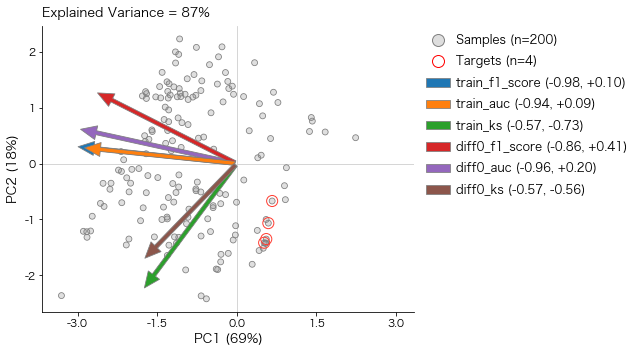

In [66]:
ax = visualize.plot(target=target0, pc_pair=(0,1), show_corr=True)

Create parameter grids from selected sets of parameters.

In [67]:
get_param_grids(np.array(RandParams0.params)[target0])

{'max_samples': [0.6, 0.7, 0.8],
 'max_features': [4, 5, 6, 9],
 'max_depth': [3],
 'criterion': ['entropy', 'gini'],
 'class_weight': [{0: 1.0864, 1: 7.5114}, {0: 1.0576, 1: 5.341}]}

We can narrow down the search by selecting those parameters that satisfy the defined criteria.

In [68]:
param_grids1 = {'max_depth'    : [4],  
                'class_weight' : get_classweights([1.0576, 5.3410], 
                                                  [1.0864, 7.5114], num=10),
                'max_features' : [4, 5, 6, 9], 
                'criterion'    : ['entropy', 'gini'], 
                "max_samples"  : [0.6, 0.7, 0.8]}

In [69]:
RandParams1 = Modified_RandomizedSearch(estimator, param_grids1, **kwds)
RandParams1.fit(X_train, y_train, [(X_test,y_test)])

In [70]:
pd.DataFrame(RandParams1.results).head()

,train_f1_score,train_auc,train_ks,test0_f1_score,test0_auc,test0_ks
0,0.6830,0.9382,0.4522,0.6194,0.9080,0.3788
1,0.6921,0.9403,0.4206,0.6326,0.9108,0.3508
2,0.6981,0.9370,0.4167,0.6377,0.9077,0.3593
3,0.6835,0.9367,0.4313,0.6135,0.9067,0.4028
4,0.6860,0.9367,0.4445,0.6180,0.9085,0.3781


In [71]:
results1 = pd.DataFrame(find_delta(RandParams1))
results1.head()

,train_f1_score,train_auc,train_ks,diff0_f1_score,diff0_auc,diff0_ks
0,0.6830,0.9382,0.4522,0.0636,0.0302,0.0734
1,0.6921,0.9403,0.4206,0.0596,0.0295,0.0698
2,0.6981,0.9370,0.4167,0.0604,0.0293,0.0574
3,0.6835,0.9367,0.4313,0.0700,0.0299,0.0285
4,0.6860,0.9367,0.4445,0.0680,0.0282,0.0664


In [73]:
target1 = ((results1["train_f1_score"]>0.6) & 
           (results1["train_auc"]>0.9)  & 
           (results1["diff0_ks"]<0.001)  & 
           (results1["diff0_auc"]<0.03))
print("{:,d} target(s) found.".format(target1.sum()))

2 target(s) found.


In [74]:
visualize = PrincipalComponents(minprop=0.8, mineigval=1.0).fit(results1)

In [75]:
n_components = len(visualize.results_.eigvals)
print("There are {:,d} components.".format(n_components))

There are 4 components.


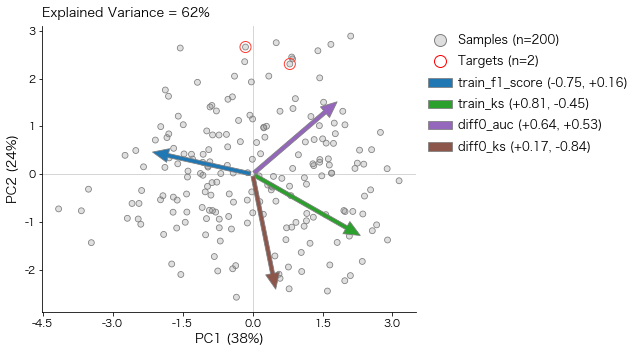

In [76]:
ax = visualize.plot(target=target1, pc_pair=(0,1), show_corr=True)

In [77]:
get_param_grids(np.array(RandParams1.params)[target1])

{'max_samples': [0.8],
 'max_features': [9],
 'max_depth': [4],
 'criterion': ['entropy'],
 'class_weight': [{0: 1.0736, 1: 6.5468}, {0: 1.0608, 1: 5.5822}]}

In [78]:
results1[target1]

,train_f1_score,train_auc,train_ks,diff0_f1_score,diff0_auc,diff0_ks
150,0.6756,0.9392,0.4414,0.0565,0.0297,-0.0088
167,0.6793,0.9395,0.4169,0.0667,0.0298,-0.0073


In [79]:
best_params = np.array(RandParams1.params)[150]
best_params

{'max_samples': 0.8,
 'max_features': 9,
 'max_depth': 4,
 'criterion': 'entropy',
 'class_weight': {0: 1.0736, 1: 6.5468}}

Select set of parameters that perform the best given evaluation metrics.

In [80]:
params = {**estimator.get_params(), **best_params}
clf = RandomForestClassifier(**params).fit(X_train, y_train)
y_train_proba = clf.predict_proba(X_train)[:,1]
y_test_proba  = clf.predict_proba(X_test )[:,1]

Specify parameters for **`eval_classifier`** and build plotting function.

In [81]:
evaluate = eval_classifier(plots = ["f1", "gini", "hist", "cumu"], 
                           ax_dict = {"hist":{"bins":20}}, n_columns=2)

Observe performace of **X_train** after retraining classifier.

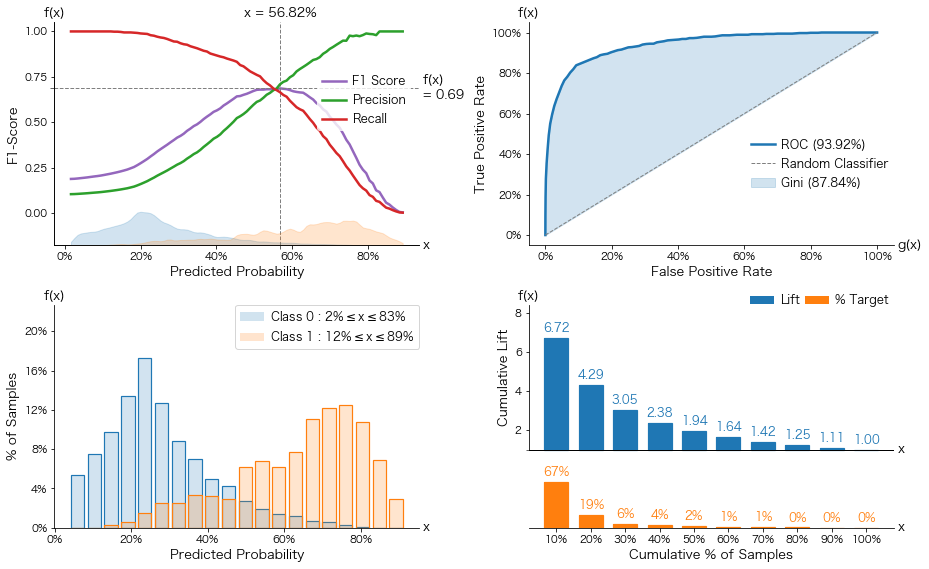

In [82]:
axes = evaluate.plot_all(y_train, y_train_proba)

Validate performace of model with unseen data, **X_test**.

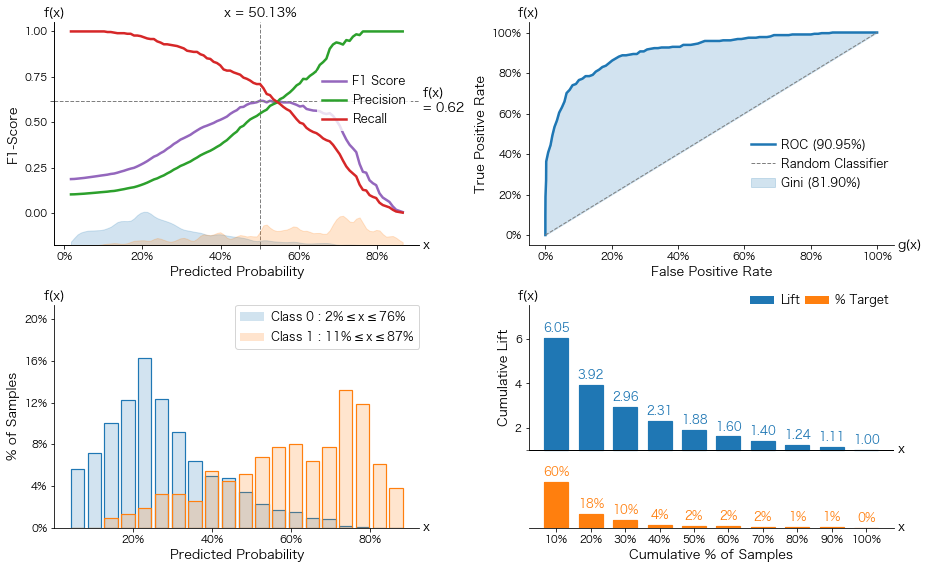

In [83]:
axes = evaluate.plot_all(y_test, y_test_proba)

**Importance Values**
- sklearn (average decrease in impurity or Information Gain)
- Directional Feature Contributions (DFC)
- Permute variable (Permutation Importance)
- Drop variable (Drop-Column Importance)

In [84]:
importance = FeatureImportance().fit(clf, X_train, y_train)

In [85]:
importance.info.head(10)

,gain_score,dfc_score,permute_score,drop_score,mean_score
features,,,,,
feature_028,0.1482,0.1379,0.2052,0.1530,0.1612
feature_071,0.1107,0.1482,0.1337,0.0918,0.1212
feature_029,0.0727,0.0603,0.1287,0.1559,0.1044
feature_119,0.1114,0.0769,0.1315,0.0273,0.0868
feature_188,0.0629,0.0736,0.0556,0.0787,0.0677
feature_024,0.0567,0.0752,0.0650,0.0429,0.0599
feature_035,0.0677,0.0790,0.0510,0.0120,0.0524
feature_001,0.0598,0.0813,0.0238,0.0171,0.0455
feature_176,0.0393,0.0314,0.0308,0.0430,0.0361


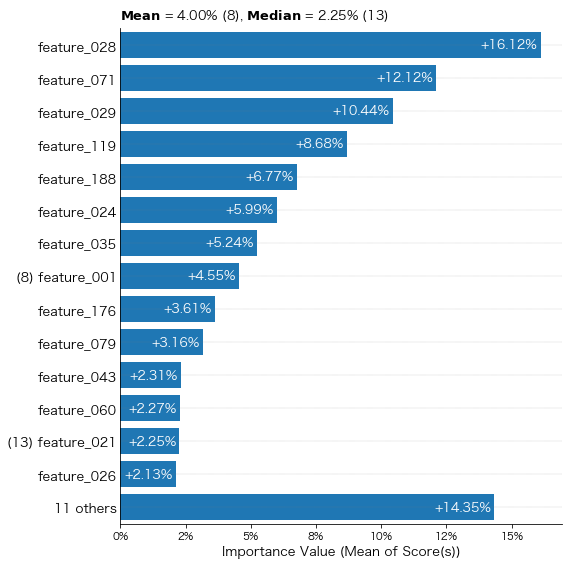

In [87]:
ax = importance.plotting(max_display=15)

Select feature(s), whose importance is equal to or greater than defined cutoff.

In [88]:
final_features = importance.info.index[:15].tolist()
final_features

['feature_028',
 'feature_071',
 'feature_029',
 'feature_119',
 'feature_188',
 'feature_024',
 'feature_035',
 'feature_001',
 'feature_176',
 'feature_079',
 'feature_043',
 'feature_060',
 'feature_021',
 'feature_026',
 'feature_019']

### <font color="green" size=5> Retrain classifier </font>

Retrain model with new set of variables and validate fitted model accordingly.

In [89]:
n_features = len(final_features)
param_grids2 = {"max_depth"    : np.arange(3, np.ceil(np.log2(n_samples))).astype(int),  
                "class_weight" : get_classweights(y=y_train, num=5),
                "max_features" : np.arange(np.floor(max(np.log2(n_features), 
                                                        np.sqrt(n_features))-1), 7).astype(int), 
                "criterion"    : ["gini","entropy"], 
                "max_samples"  : [0.5, 0.6, 0.7, 0.8, 0.9, 1]}

In [90]:
RandParams2 = Modified_RandomizedSearch(estimator, param_grids2, **kwds)
RandParams2.fit(X_train, y_train, [(X_test,y_test)])

In [91]:
pd.DataFrame(RandParams2.results).head()

,train_f1_score,train_auc,train_ks,test0_f1_score,test0_auc,test0_ks
0,0.0000,0.5000,0.1167,0.0000,0.5000,0.1167
1,0.0000,0.5000,0.1167,0.0000,0.5000,0.1167
2,0.7414,0.9585,0.3963,0.6730,0.9227,0.3827
3,0.9338,0.9979,0.3278,0.7333,0.9425,0.2636
4,0.9741,0.9998,0.3734,0.7509,0.9481,0.2319


In [92]:
results2 = pd.DataFrame(find_delta(RandParams2))
results2.head()

,train_f1_score,train_auc,train_ks,diff0_f1_score,diff0_auc,diff0_ks
0,0.0000,0.5000,0.1167,0.0000,0.0000,0.0000
1,0.0000,0.5000,0.1167,0.0000,0.0000,0.0000
2,0.7414,0.9585,0.3963,0.0684,0.0357,0.0136
3,0.9338,0.9979,0.3278,0.2005,0.0554,0.0642
4,0.9741,0.9998,0.3734,0.2232,0.0517,0.1415


In [96]:
target2 = ((results2["train_f1_score"]>0.6) & 
           (results2["train_auc"]>0.9)  & 
           (results2["diff0_ks"]<0.005)  & 
           (results2["diff0_auc"]<0.03))
print("{:,d} target(s) found.".format(target2.sum()))

6 target(s) found.


In [157]:
visualize = PrincipalComponents(method="eigval", mineigval=0.8).fit(results2)

In [158]:
n_components = len(visualize.results_.eigvals)
print("There are {:,d} components.".format(n_components))

There are 2 components.


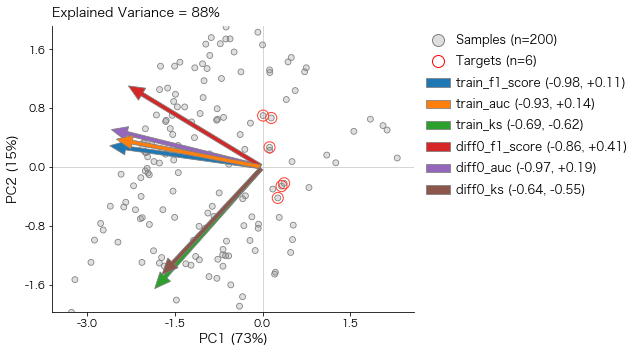

In [160]:
ax = visualize.plot(target=target2, pc_pair=(0,1), whis=1, show_corr=True)

In [100]:
get_param_grids(np.array(RandParams2.params)[target2])

{'max_samples': [0.5, 0.6, 0.7, 0.8],
 'max_features': [2, 3, 6],
 'max_depth': [4, 5],
 'criterion': ['entropy', 'gini'],
 'class_weight': [{0: 1.0576, 1: 5.341}, {0: 1.0288, 1: 3.1705}]}

In [101]:
results2[target2]

,train_f1_score,train_auc,train_ks,diff0_f1_score,diff0_auc,diff0_ks
8,0.6794,0.9340,0.3754,0.0534,0.0261,-0.0095
51,0.6589,0.9252,0.3779,0.0566,0.0263,-0.0131
66,0.6588,0.9279,0.3719,0.0519,0.0274,0.0042
87,0.7386,0.9521,0.2928,0.0842,0.0287,0.0007
96,0.6415,0.9449,0.2789,0.1451,0.0285,-0.0037
124,0.6139,0.9438,0.2784,0.1308,0.0288,-0.0079


In [171]:
best_params = np.array(RandParams2.params)[8]
best_params

{'max_samples': 0.6,
 'max_features': 3,
 'max_depth': 4,
 'criterion': 'entropy',
 'class_weight': {0: 1.0576, 1: 5.341}}

In [172]:
params = {**estimator.get_params(), **best_params}
clf = RandomForestClassifier(**params).fit(X_train[final_features], y_train)
y_train_proba_1 = clf.predict_proba(X_train[final_features])[:,1]
y_test_proba_1  = clf.predict_proba(X_test[final_features] )[:,1]

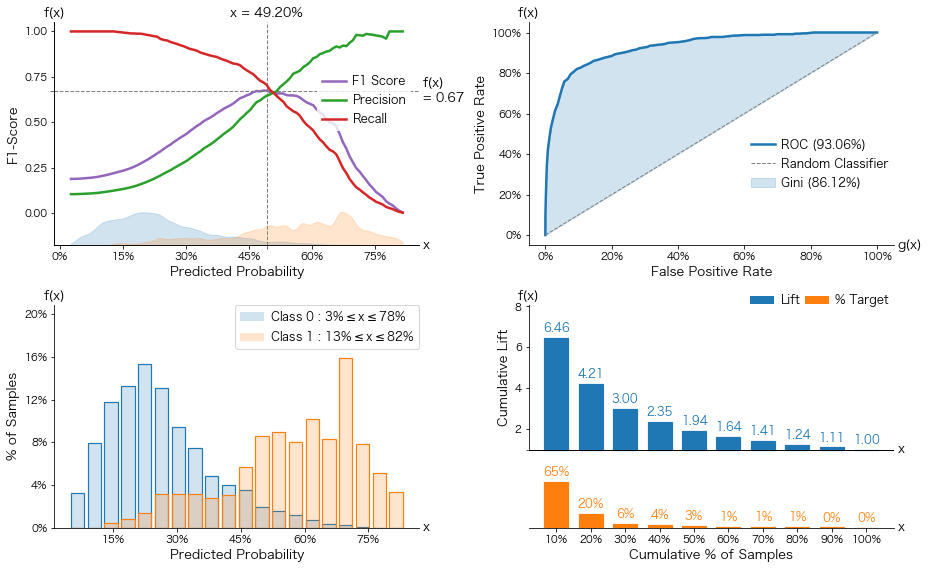

In [173]:
axes = evaluate.plot_all(y_train, y_train_proba_1)

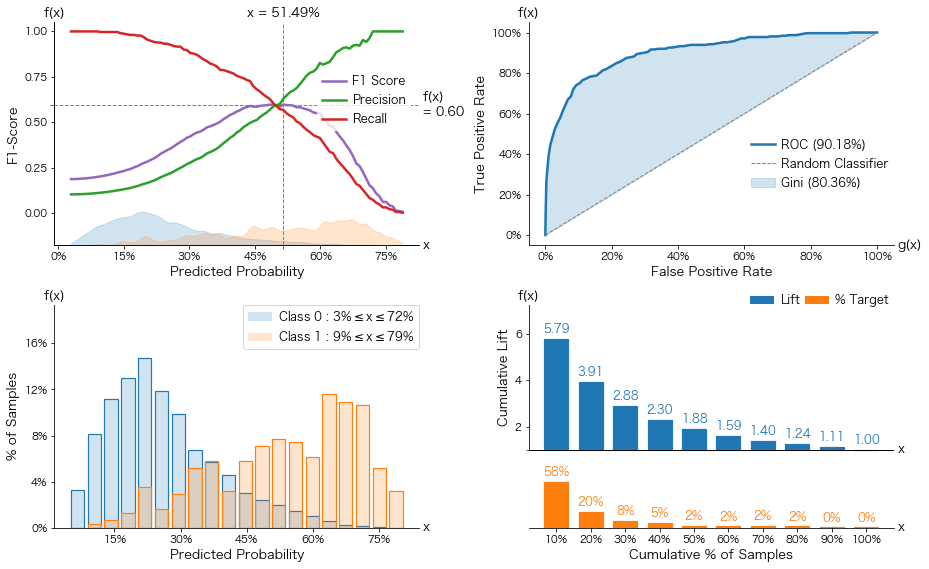

In [174]:
axes = evaluate.plot_all(y_test, y_test_proba_1)

We will use **`TreeExplainer`** to observe the relationship between feature contributions and variables. This type of visualization will facilitate an understanding of which features are important for the classification.

In [175]:
clf_explain = TreeExplainer(clf).fit(X_train[final_features], y_train)

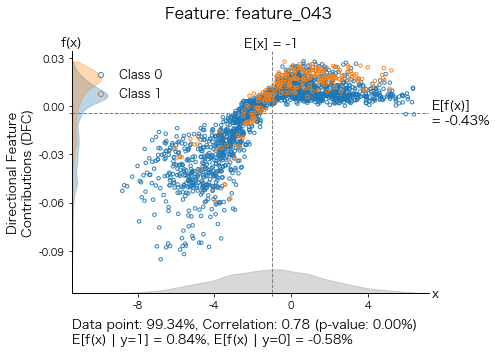

In [176]:
var= np.random.choice(final_features)
ax = clf_explain.scatter(var, frac=0.3, by_class=False, draw_trend=False)
plt.gcf().suptitle(f"Feature: {var}", fontsize=16)
plt.tight_layout()

Directional feature contribution can be seen as an average incremental increase/decrease probability from bias. The scatter plot **`scatter()`** illustrates the relationship between $x$ and Directional Feature Contribution towards better understanding of how change in $x$ affects the prediction. The trend line is just a linear approximation and shall not be considered as a true relationship.

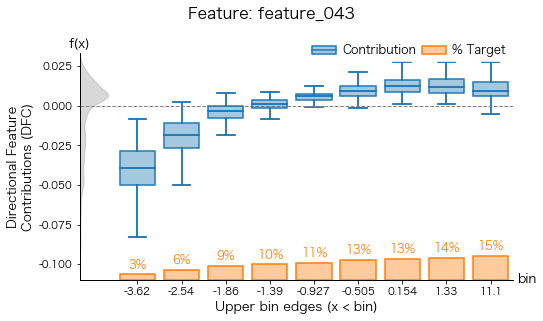

In [177]:
ax = clf_explain.boxplot(var, by_class=False)
plt.gcf().suptitle(f"Feature: {var}", fontsize=16)
plt.tight_layout()

In box plot **`boxplot()`**, Multi-Interval Discretization (modified) is applied to divide $x$ into bins towards monotonic trend (increase/decrease) of percentage of targets. This introduces a linear relationship between directional feature contribution and target, and enables us to understand in the most simplest way.

index: 3343


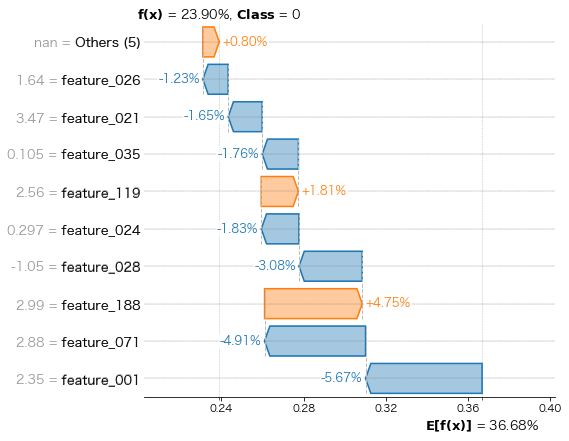

In [179]:
index = np.random.randint(len(X_train))
print(f"index: {index}")
ax = clf_explain.waterfall(index=index, sort_by="contribution")

The prediction function can be expressed as $f(x) = \frac{1}{J}\sum_{j=1}^{J} c_{j} + \sum_{k=1}^{K} (\frac{1}{J}\sum_{j=1}^{J} contrib_{j}(x,k))$ where $J$ is the number of trees in the forest, $K$ is the number of features, $c_{j}$ is the value at the root of the node of $j^{th}$ tree (bias), and $contrib(x,k)$ is the contribution from the $k^{th}$ feature in the feature vector $x$. From the equation, Directional Feature Contributions, **DFC** always sum up to the difference between the average value at every root node and prediction. The simplest way to see this is through a waterfall plot **`waterfall()`** that starts from an average value of root nodes, and then adds contribution features one at a time until we reach the prediction.

### <font color="green" size=5> Calibration of probability </font>

The purpose of [`calibration`](https://scikit-learn.org/stable/modules/calibration.html)  is to improve estimated probabilities, which can be directly interpreted as a confidence level. For instance a well calibrated (binary) classifier should classify the samples such that among the samples to which it gave a **`predict_proba`** value close to 0.8, approx. 80% actually belong to the positive class. The samples that are used to fit the calibrator should not be the same samples used to fit the classifier, as this would introduce bias. Using logistic regression as a calibrator, we are trying to find the optimal set of coefficients that yields the smallest difference of given evaluation metrics e.g. [**`log_loss`**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html). 

Please be noted that the following example does not conclude the optimal way of calibration.

In [180]:
estimator = LogisticRegression(max_iter=500, tol=1e-4)
exponents = np.arange(3, 15, 0.1)
loss = []
for exp in exponents:
    estimator.fit((exp**y_test_proba_1).reshape(-1,1), y_test)
    y_pred = (exp**y_train_proba_1).reshape(-1,1)
    loss  += [log_loss(y_train, estimator.predict_proba(y_pred)[:,1])]
print("Exponent : {:,.2f}".format(exponents[np.argmin(loss)]))

Exponent : 5.40


Fit calibrator.

In [181]:
exponent = 5.4
deciaml  = 4
calib_train = np.round((exponent**y_test_proba_1) , deciaml).reshape(-1,1)
calib_test  = np.round((exponent**y_train_proba_1), deciaml).reshape(-1,1)
calibrator  = LogisticRegression(max_iter=500, tol=1e-4).fit(calib_train, y_test)

Use **`CalibatorEvaluation`** to evaluate the calibrated probabilities.

In [121]:
train  = (y_test , calibrator.predict_proba(calib_train)[:,1])
test   = (y_train, calibrator.predict_proba(calib_test )[:,1])
calibr = CalibatorEvaluation(equal_width=False, bins=range(2,26)).fit(train, test)

Use **`plotting_metric()`** to observe how change in number of bins can affect evaluation metrics i.e. gini impurity (`gini`), and R-Squared (`r2`).

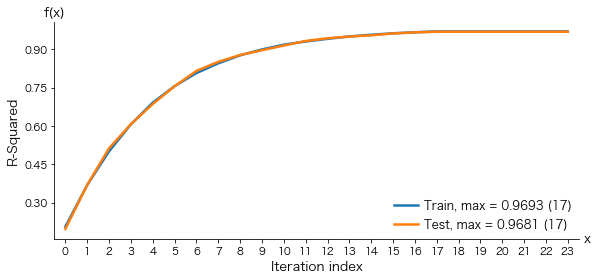

In [122]:
ax = calibr.plotting_metric("r2")

Use **`plotting_reliability()`** to plot calibration curve or so-called **reliability curve**.

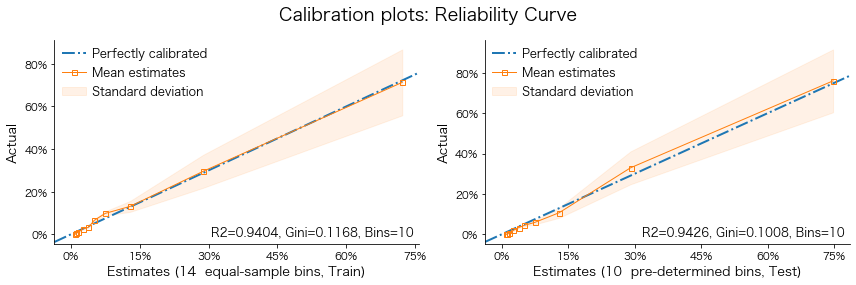

In [146]:
n_iter = 12
axes = plt.subplots(1,2,figsize=(12, 4))[1]
ax = calibr.plotting_reliability(n_iter, use_train=True , ax=axes[0], tight_layout=False)
ax = calibr.plotting_reliability(n_iter, use_train=False, ax=axes[1], tight_layout=False)
plt.gcf().suptitle('Calibration plots: Reliability Curve', fontsize=18)
plt.tight_layout()

Use **`plotting_hist()`** to enable us to compare calibrated estimates and actual percentage.

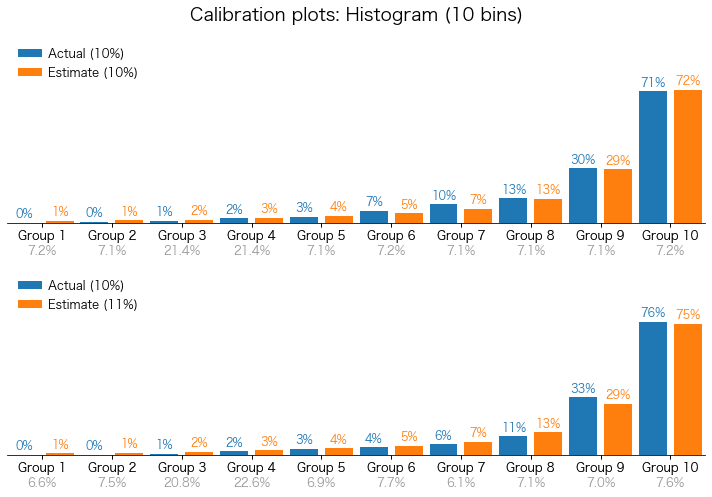

In [147]:
axes = plt.subplots(2, 1,figsize=(10,7))[1]
calibr.plotting_hist(n_iter, use_train=True , ax=axes[0], tight_layout=False)
calibr.plotting_hist(n_iter, use_train=False, ax=axes[1], tight_layout=False)
n_bins = calibr.result[n_iter].train.info.shape[0]
plt.gcf().suptitle("Calibration plots: Histogram ({:,d} bins)"
                   .format(n_bins), fontsize=18)
plt.tight_layout()

Summary table

In [148]:
calibr.result[n_iter].train.info

,r_min,r_max,p_samples,min_proba,max_proba,mean_proba,std_proba,p_targets
0,0.0000,0.0103,0.0717,0.0071,0.0103,0.0090,0.0008,0.0000
1,0.0103,0.0124,0.0713,0.0103,0.0124,0.0113,0.0007,0.0047
2,0.0124,0.0199,0.2143,0.0124,0.0199,0.0160,0.0022,0.0109
3,0.0199,0.0338,0.2140,0.0200,0.0338,0.0255,0.0039,0.0249
4,0.0338,0.0427,0.0713,0.0338,0.0426,0.0380,0.0026,0.0327
5,0.0427,0.0605,0.0717,0.0427,0.0605,0.0505,0.0052,0.0651
6,0.0605,0.0924,0.0713,0.0609,0.0923,0.0747,0.0096,0.0981
7,0.0924,0.1792,0.0713,0.0925,0.1790,0.1288,0.0255,0.1308
8,0.1792,0.4551,0.0710,0.1793,0.4525,0.2883,0.0774,0.2958
9,0.4551,1.0000,0.0720,0.4551,0.9770,0.7222,0.1545,0.7130


Calibrate the estimates from initial estimator.

In [149]:
z = np.round(exponent**clf.predict_proba(X[final_features])[:,1], deciaml) 
z = z * calibrator.coef_ + calibrator.intercept_
estimates = (1/(1 + np.exp(-z))).ravel()

Assign probabilities into groups with respect to `bin_edges`.

In [150]:
bin_edges   = calibr.result[n_iter].train.bin_edges
group_proba = np.digitize(estimates, bin_edges)

### <font color="green" size=5> Score </font>

Use **`cal_score()`** to convert probability into score.

In [151]:
p_min = 0.0001
score_kwds = dict(pdo=20, point=0, odd=p_min/(1-p_min))

In [152]:
final_group = pd.DataFrame(calibr.result[n_iter].train.info)
final_group["min_score"] = cal_score(final_group["r_min"], **score_kwds).astype(int)
final_group["max_score"] = cal_score(final_group["r_max"], **score_kwds).astype(int)
final_group["group"] = np.arange(1, len(final_group)+1)

In [153]:
final_group.set_index("group")

,r_min,r_max,p_samples,min_proba,max_proba,mean_proba,std_proba,p_targets,min_score,max_score
group,,,,,,,,,,
1,0.0000,0.0103,0.0717,0.0071,0.0103,0.0090,0.0008,0.0000,0,134
2,0.0103,0.0124,0.0713,0.0103,0.0124,0.0113,0.0007,0.0047,134,139
3,0.0124,0.0199,0.2143,0.0124,0.0199,0.0160,0.0022,0.0109,139,153
4,0.0199,0.0338,0.2140,0.0200,0.0338,0.0255,0.0039,0.0249,153,169
5,0.0338,0.0427,0.0713,0.0338,0.0426,0.0380,0.0026,0.0327,169,176
6,0.0427,0.0605,0.0717,0.0427,0.0605,0.0505,0.0052,0.0651,176,187
7,0.0605,0.0924,0.0713,0.0609,0.0923,0.0747,0.0096,0.0981,187,200
8,0.0924,0.1792,0.0713,0.0925,0.1790,0.1288,0.0255,0.1308,200,222
9,0.1792,0.4551,0.0710,0.1793,0.4525,0.2883,0.0774,0.2958,222,261


### <font color="green" size=5> Save datasets </font>


In [154]:
final_X = X[final_features].copy()
final_X["target"] = y
final_X["proba"]  = estimates
final_X["train"]  = np.where(final_X.index.isin(X_train.index), 1, 0)
final_X["group"]  = group_proba
final_X["score"]  = cal_score(estimates, **score_kwds).astype(int)
final_X = final_X.merge(final_group[["group"]], how="left", on="group")

In [155]:
final_X.head()

,feature_028,feature_071,feature_029,feature_119,feature_188,feature_024,feature_035,feature_001,feature_176,feature_079,feature_043,feature_060,feature_021,feature_026,feature_019,target,proba,train,group,score
0,-3.2760,4.1260,4.3377,5.5852,0.6877,2.6354,-1.6286,2.9023,0.5976,-0.9238,-1.3473,-4.4099,-2.7386,2.0517,-4.6545,0,0.0117,1,2,138
1,0.3648,7.4796,2.5139,4.7239,-5.2424,-1.2602,3.8371,4.3501,7.5761,-2.3266,0.4619,-5.8558,4.0022,-0.2721,2.7647,0,0.0099,1,1,133
2,-1.4026,-1.5951,6.7638,-4.4276,-3.4444,4.6386,-2.7667,2.7799,1.9646,-6.0308,2.2587,0.8826,-0.3778,-4.5970,3.8481,0,0.0229,1,4,157
3,-1.3043,0.6799,-5.6432,-1.6098,-5.1280,-1.5494,1.2252,0.0402,-3.4431,2.5216,-3.5954,-1.2732,3.2283,-4.3928,4.2420,0,0.0344,1,5,170
4,-2.3006,3.2813,-3.7373,3.4663,-9.7390,-0.8255,5.5316,2.9126,-0.0787,1.8139,-1.4588,-1.1921,3.1172,-3.2980,4.9519,1,0.0359,1,5,171


In [ ]:
yyyymmm = 999999
final_X.to_csv(f'X_{yyyymm}.txt', index=False, sep='|')
final_group.to_csv(f'Group_{yyyymm}.txt', index=False, sep='|')

Save classifer.

In [ ]:
pickle.dump(clf, open(f'final_model_{yyyymmm}.sav','wb'))